In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display
from scipy.stats import pearsonr
import seaborn as sns
from scipy.optimize import nnls  # for non-negative least squares
from scipy.stats import linregress
import matplotlib.patches as mpatches
from pathlib import Path
import sys

rc('mathtext', default='regular')

sys.path.append(str(Path('..').resolve()))
from fun_LR_hydro_memory import *

# === Paths ===
project_root = Path.cwd().resolve()
data_dir = '../../data/camels/'
out_results = 'csv'
Path(out_results).mkdir(parents=True, exist_ok=True)

# === Global parameters ===
min_obs = 100
n_pred = 6

# IMPORTANTE!!!! #
# === Storage for exported predictors (2nd lag config) ===
# === select the predictor generation type that works best - see line "if config_idx == 0:""

selected_lag_type_q = 'type1_incr1'  
# selected_lag_type_gw = 'type2_incr4'  
 
pred_store_pr_an_dt = {f"pred{i+1}": {} for i in range(n_pred)}
pred_store_pr_an = {f"pred{i+1}": {} for i in range(n_pred)}


# === Training period for LR ===
train_start = '1960-01-01'

train_end   = '2025-12-01'
label_train = 'trained_all'

# train_end   = '2010-12-01'
# label_train = 'trained_pre_MD'

# === Load data ==
q_all = pd.read_csv(data_dir + 'camels_q_mm.csv', parse_dates=['date'])
q_all = q_all #el script ya está todo escrito con gw_all... 
pr_all = pd.read_csv(data_dir + 'camels_pr_mm.csv', parse_dates=['date'])
et_all = pd.read_csv(data_dir + 'camels_et_mm.csv', parse_dates=['date'])

clean_codes = [col for col in q_all.columns if col != 'date']
start = q_all['date'].min()
end = q_all['date'].max()

r2_summary_all = pd.DataFrame(columns=[
    'gauge_id',
    'target',
    'predictor',
    'lag_type',
    'lag_incr_rule',
    'lag_incr',
    'r2_train',
    'r2_all',
    'r2_pred1',
    'r2_pred2',
    'r2_pred3',
    'r2_pred4',
    'r2_pred5',
    'r2_pred6', 
    'has_neg_coef'
])

# === Control for overwriting the prediction CSV on first write ===
predictions_file = out_results + '/q_sim_LR_' + label_train + '.csv'
overwrite_predictions = True  # Will be set to False after first write

# === Loop through wells with ≥ min obs ===
# for cod in ['03450005','05731003', '05410014']:
# for cod in ['03450005']:
for cod in clean_codes:
    q = pd.Series(q_all[cod].values, index=q_all['date'])
    if q.notna().sum() < min_obs:
        continue  # Skip well
    pr = pd.Series(pr_all[cod].values, index=pr_all['date'])
    et = pd.Series(et_all[cod].values, index=et_all['date'])

    # Align time
    q, pr , et = q[start:end], pr[start:end], et[start:end]

    if q.notna().sum() < min_obs:
        continue  # Skip well
        

    # === Compute monthly anomalies (deseasonalize) === (computed again in case the training period is not the full period of recrd)
    q_an = q - q.groupby(q.index.month).transform('mean')
    pr_an = pr - pr.groupby(pr.index.month).transform('mean')
    et_an = et - et.groupby(et.index.month).transform('mean')

    # === De-trend ===
    # Q Detrend
    x_q = np.arange(len(q_an))
    y_q = q_an.values
    mask_q = ~np.isnan(y_q)
    
    # Q Linear trend
    q_coeffs_lin = np.polyfit(x_q[mask_q], y_q[mask_q], deg=1)
    q_trend_lin = np.polyval(q_coeffs_lin, x_q)
    q_an_dt = y_q - q_trend_lin

    # Pr Detrend
    x_pr = np.arange(len(pr_an))
    y_pr = pr_an.values
    mask_pr = ~np.isnan(y_pr)
    pr_coeffs_lin = np.polyfit(x_pr[mask_pr], y_pr[mask_pr], deg=1)
    pr_trend_lin = np.polyval(pr_coeffs_lin, x_pr)
    pr_an_dt = y_pr - pr_trend_lin

    # ET Detrend
    x_et = np.arange(len(et_an))
    y_et = et_an.values
    mask_et = ~np.isnan(y_et)
    et_coeffs_lin = np.polyfit(x_et[mask_et], y_et[mask_et], deg=1)
    et_trend_lin = np.polyval(et_coeffs_lin, x_et)
    et_an_dt = y_et - et_trend_lin  

    ### Create predictors for LR (moving window mean precip)
    pr_an_dt = pd.Series(pr_an_dt, index=pr.index, name='an_dt')
    pr_an = pd.Series(pr_an, index=pr.index, name='an')    
    et_an_dt = pd.Series(et_an_dt, index=et.index, name='an_dt')
    et_an = pd.Series(et_an, index=et.index, name='an')   

    lag_configs = [
        {"incr_type": 1, "lag_increase": 1},
        {"incr_type": 2, "lag_increase": 1},
        {"incr_type": 3, "lag_increase": 1}
    ]

    # estos eran los lag_increase de GW. para caudal es más corto
    # lag_configs = [
    #     {"incr_type": 1, "lag_increase": 4},
    #     {"incr_type": 2, "lag_increase": 4},
    #     {"incr_type": 3, "lag_increase": 2}
    # ]

    lag_ranges_all = {}
    
    for config_idx, config in enumerate(lag_configs):
        incr_type = config["incr_type"]
        lag_increase = config["lag_increase"]
        lag_type_label = f"type{incr_type}_incr{lag_increase}"
        
        lag_ranges, widths, incr_name = make_lag_ranges(
            lag_increase=lag_increase,
            n_windows=n_pred,
            incr_type=incr_type
        )

        # precip
        # pred_pr_raw   = rolling_predictors(pr, lag_ranges, standardize=True)
        pred_pr_an_dt = rolling_predictors(pr_an_dt, lag_ranges, standardize=True)
        pred_pr_an    = rolling_predictors(pr_an,    lag_ranges, standardize=True)

        if lag_type_label == selected_lag_type_q: # Save predictors only for one configuration
            for pred_idx, col_name in enumerate(pred_pr_an_dt.columns):
                pred_key = f"pred{pred_idx + 1}"
                pred_store_pr_an_dt[pred_key][cod] = pred_pr_an_dt[col_name]
                pred_store_pr_an[pred_key][cod] = pred_pr_an[col_name]

#         # ET too
#         pred_et_an_dt = rolling_predictors(et_an_dt, lag_ranges, standardize=True)
#         pred_et_an    = rolling_predictors(et_an,    lag_ranges, standardize=True)

        # --- Targets ---
        targets = {
            'q_an': pd.Series(q_an, name='q_an', index=q_an.index),
            'q_an_dt': pd.Series(q_an_dt, name='q_an_dt', index=q_an.index)
        }

        # --- Predictor/target combinations ---
        combinations = [
            ('q_an', 'pr_an', pred_pr_an, 'Q_an=linreg(P_an)'),
            ('q_an', 'pr_an_dt', pred_pr_an_dt, 'Q_an=linreg(P_an_dt)'),
            ('q_an_dt', 'pr_an_dt', pred_pr_an_dt, 'Q_an_dt=linreg(P_an_dt)')
        ]
      
        coeffs_df = pd.DataFrame(index=pred_pr_an.columns)

        ############# IMPORTANT TO SET TUP #########
        # Set to True to restrict to non-negative coefficients
        restrict_positive = False

        for i, (target_name, pred_name, pred_df, label) in enumerate(combinations):
                        
            y = targets[target_name]
            # Training period
            y_train_period = y.loc[train_start:train_end]
            X_train_period = pred_df.loc[train_start:train_end]
            df_train = pd.concat([y_train_period, X_train_period], axis=1).dropna()
            
            X_train = df_train.drop(columns=target_name).values
            y_train = df_train[target_name].values
            
            if pd.Series(y_train).notna().sum() < min_obs:
                continue  # Skip well
            # Fit model
            if restrict_positive:
                coef, _ = nnls(X_train, y_train)
            else:
                coef, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
                coef1, _, _, _ = np.linalg.lstsq(X_train[:,0:1], y_train, rcond=None)
                coef2, _, _, _ = np.linalg.lstsq(X_train[:,0:2], y_train, rcond=None)
                coef3, _, _, _ = np.linalg.lstsq(X_train[:,0:3], y_train, rcond=None)
                coef4, _, _, _ = np.linalg.lstsq(X_train[:,0:4], y_train, rcond=None)
                coef5, _, _, _ = np.linalg.lstsq(X_train[:,0:5], y_train, rcond=None)
                coef6, _, _, _ = np.linalg.lstsq(X_train[:,0:6], y_train, rcond=None)
            
            # Save coefficients
            # coeffs_df[label] = pd.Series(coef, index=pred_df.columns)

            # Predict for full period
            X_pred = pred_df
            y_pred_full = pd.Series(index=pred_df.index, dtype=float)
            y_pred1_full = pd.Series(index=pred_df.index, dtype=float)
            y_pred2_full = pd.Series(index=pred_df.index, dtype=float)
            y_pred3_full = pd.Series(index=pred_df.index, dtype=float)
            y_pred4_full = pd.Series(index=pred_df.index, dtype=float)
            y_pred5_full = pd.Series(index=pred_df.index, dtype=float)
            y_pred6_full = pd.Series(index=pred_df.index, dtype=float)
            
            y_pred = X_pred.values @ coef
            y_pred1 = X_pred.values[:,0:1] @ coef1
            y_pred2 = X_pred.values[:,0:2] @ coef2
            y_pred3 = X_pred.values[:,0:3] @ coef3
            y_pred4 = X_pred.values[:,0:4] @ coef4
            y_pred5 = X_pred.values[:,0:5] @ coef5
            y_pred6 = X_pred.values[:,0:6] @ coef6

            y_pred_full.loc[X_pred.index] = y_pred
            y_pred1_full.loc[X_pred.index] = y_pred1
            y_pred2_full.loc[X_pred.index] = y_pred2
            y_pred3_full.loc[X_pred.index] = y_pred3
            y_pred4_full.loc[X_pred.index] = y_pred4
            y_pred5_full.loc[X_pred.index] = y_pred5
            y_pred6_full.loc[X_pred.index] = y_pred6        

            y_target_val = y.loc[pred_df.index]
            y_raw_obs = q.loc[pred_df.index]

            pred_out = pd.DataFrame({
                "date": pred_df.index,
                "gauge_id": cod,
                "target": target_name,
                "predictor": pred_name,
                "lr_label": label,
                "lag_type":lag_type_label,
                "lag_incr_rule": incr_name,
                "lag_incr": lag_increase,
                "raw_obs": y_raw_obs,
                "target_val": y_target_val.values,
                "pred": y_pred_full.values
            })

            pred_out.to_csv(
                predictions_file,
                mode='w' if overwrite_predictions else 'a',
                header=overwrite_predictions,
                index=False
            )
            overwrite_predictions = False  # After first write, switch to append mode

            # R² (full)
            mask_all = y.notna() & y_pred_full.notna()            
            if np.std(y_pred_full[mask_all]) == 0 or np.std(y[mask_all]) == 0:
                r2_all = np.nan
                r2_pred1 = np.nan
                r2_pred2 = np.nan
                r2_pred3 = np.nan
                r2_pred4 = np.nan
                r2_pred5 = np.nan
                r2_pred6 = np.nan
            else:
                corr_all = np.corrcoef(y[mask_all], y_pred_full[mask_all])[0, 1]
                r2_all = corr_all**2 if not np.isnan(corr_all) else np.nan
                r2_pred1 = pearsonr(y[mask_all], y_pred1_full[mask_all])[0]**2
                r2_pred2 = pearsonr(y[mask_all], y_pred2_full[mask_all])[0]**2
                r2_pred3 = pearsonr(y[mask_all], y_pred3_full[mask_all])[0]**2
                r2_pred4 = pearsonr(y[mask_all], y_pred4_full[mask_all])[0]**2
                r2_pred5 = pearsonr(y[mask_all], y_pred5_full[mask_all])[0]**2
                r2_pred6 = pearsonr(y[mask_all], y_pred6_full[mask_all])[0]**2

            # R² (train)
            mask_train = y_train_period.notna() & y_pred_full.notna()
            if np.std(y_pred_full[mask_train]) == 0 or np.std(y[mask_train]) == 0:
                r2_train = np.nan
            else:
                corr_train = np.corrcoef(y_train_period[mask_train], y_pred_full[mask_train])[0, 1]
                r2_train = corr_train**2 if not np.isnan(corr_train) else np.nan

            # Store R2 results
            has_neg = (coef < 0).any()

            r2_summary_all = pd.concat([
            r2_summary_all,
            pd.DataFrame([{
                "gauge_id": cod,
                "target": target_name,
                "predictor": pred_name,
                "lr_label": label,
                "lag_type":lag_type_label,
                "lag_incr_rule": incr_name,
                "lag_incr": lag_increase,
                "lag_ranges": str(lag_ranges),
                "r2_train": r2_train,
                "r2_all": r2_all,
                "r2_pred1": r2_pred1,
                "r2_pred2": r2_pred2,
                "r2_pred3": r2_pred3,
                "r2_pred4": r2_pred4,
                "r2_pred5": r2_pred5,
                "r2_pred6": r2_pred6,  
                "has_neg_coef": has_neg
            }])
            ], ignore_index=True)

output_base = Path(data_dir)
output_base.mkdir(parents=True, exist_ok=True)

for pred_idx in range(n_pred):
    pred_key = f"pred{pred_idx + 1}"
    if pred_store_pr_an_dt[pred_key]:
        df_pr_an_dt = pd.DataFrame(pred_store_pr_an_dt[pred_key]).sort_index()
        df_pr_an_dt = df_pr_an_dt.reset_index().rename(columns={'index': 'date'})
        df_pr_an_dt.to_csv(output_base / f"camels_pr_an_dt_{pred_key}_{selected_lag_type_q}.csv", index=False)
    if pred_store_pr_an[pred_key]:
        df_pr_an = pd.DataFrame(pred_store_pr_an[pred_key]).sort_index()
        df_pr_an = df_pr_an.reset_index().rename(columns={'index': 'date'})
        df_pr_an.to_csv(output_base / f"camels_pr_an_{pred_key}_{selected_lag_type_q}.csv", index=False)

# Add column to identify whether this run used positive coefficient restriction
r2_summary_all['LR_restrict_positive'] = restrict_positive  # or False, depending on the run
r2_summary_all.to_csv(f"{out_results}/r2_LR_rest_pos_{r2_summary_all['LR_restrict_positive'].iloc[0]}_{label_train}.csv", index=False)     
print("\nLR models Finished! \nFinito! \nTerminado!\n")

/var/folders/mm/nd9j2p7s4d1fmw46jbmnzdvr0000gn/T/ipykernel_18327/1117834203.py:306: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  r2_summary_all = pd.concat([



LR models Finished! 
Finito! 
Terminado!



In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_r2_by_target(df, combinations, thr_r2=0.0, title_suffix="", filename="r2_merged_targets", out_figs="figures"):
    """
    Creates a figure with:
    - Two boxplots per target (for r2_train and r2_all) showing R² per lag, grouped by predictor.
    - One bar plot showing the number of wells (y) with R² > threshold per lag (x), per combination.
    """
    # === Prep combinations info ===
    used_combos = [(t, p) for (t, p, _, _) in combinations]
    label_map = {(t, p): label for (t, p, _, label) in combinations}
    pred_label_map = {(t, p): label.split('= f (')[-1].rstrip(')') for (t, p, _, label) in combinations}
    targets = sorted(set(t for t, _, _, _ in combinations))

    # === Filter R² data ===
    df = df[df[['target', 'predictor']].apply(tuple, axis=1).isin(used_combos)].copy()
    # df = df[(df['r2_train'] > thr_r2) | (df['r2_all'] > thr_r2)]
    df = df[(df['r2_train'] > thr_r2)]
    df['combo_label'] = df.apply(lambda row: label_map.get((row['target'], row['predictor'])), axis=1)
    df['predictor_label'] = df.apply(lambda row: pred_label_map.get((row['target'], row['predictor'])), axis=1)

    # === Melt to long format for r2_train and r2_all ===
    df_long = df.melt(
        id_vars=['gauge_id', 'target', 'predictor', 'lag_type', 'predictor_label'],
        value_vars=['r2_train', 'r2_all'],
        var_name='r2_type',
        value_name='r2'
    )

    # === Count summary ===
    count_df = (
        df[df['r2_all'] > thr_r2]
        .groupby(['target', 'predictor', 'lag_type'])['gauge_id']
        .nunique()
        .reset_index(name='n_wells')
    )
    count_df['combo_label'] = count_df.apply(lambda row: label_map.get((row['target'], row['predictor'])), axis=1)

    # === Setup 3-panel figure ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    for i, t in enumerate(targets):
        ax = axs[i]
        df_plot = df_long[df_long['target'] == t]
        if df_plot.empty:
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.set_axis_off()
            continue

        sns.boxplot(
            data=df_plot,
            x='lag_type',
            y='r2',
            hue='r2_type',
            ax=ax,
            width=0.6,
            palette={'r2_train': 'skyblue', 'r2_all': 'orange'}
        )

        # Add number of wells on top
        xtick_labels = list(df_plot['lag_type'].unique())
        xtick_positions = {label: i for i, label in enumerate(xtick_labels)}
        grouped = df[df['target'] == t].groupby(['lag_type', 'predictor_label'])['gauge_id'].nunique().reset_index(name='count')
        for j, pred in enumerate(df['predictor_label'].unique()):
            for lag in sorted(df['lag_type'].unique()):
                subset = grouped[(grouped['lag_type'] == lag) & (grouped['predictor_label'] == pred)]
                if not subset.empty:
                    count = subset['count'].values[0]
                    xpos = xtick_positions[lag] + j * 0.15 - 0.25
                    ax.text(x=xpos, y=1.01, s=f"n={count}",
                            ha='center', va='bottom', fontsize=7, rotation=90,
                            transform=ax.get_xaxis_transform())

        ax.set_ylim(0, 1)
        ax.text(0.5, 1.13, f"Target: {t} {title_suffix}", transform=ax.transAxes, ha='center', fontsize=10)
        ax.set_xlabel("Lag type")
        ax.set_ylabel("R²" if i == 0 else "")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        if i == 0:
            ax.legend(title='R² type', fontsize=8, loc='lower right')
        else:
            ax.get_legend().remove()

    # === fourth panel: Barplot of number of wells with R² > threshold ===
    ax = axs[2]
    sns.barplot(
        data=count_df,
        x='lag_type',
        y='n_wells',
        hue='combo_label',
        ax=ax
    )
    # ax.set_ylim(0, 350)
    ax.set_title(f"# of wells with R² > {thr_r2}")
    ax.set_xlabel("lag_type")
    ax.set_ylabel("Number of basins")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(title="Combination", fontsize=8, loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{out_figs}/{filename}.png", bbox_inches='tight')
    plt.show()




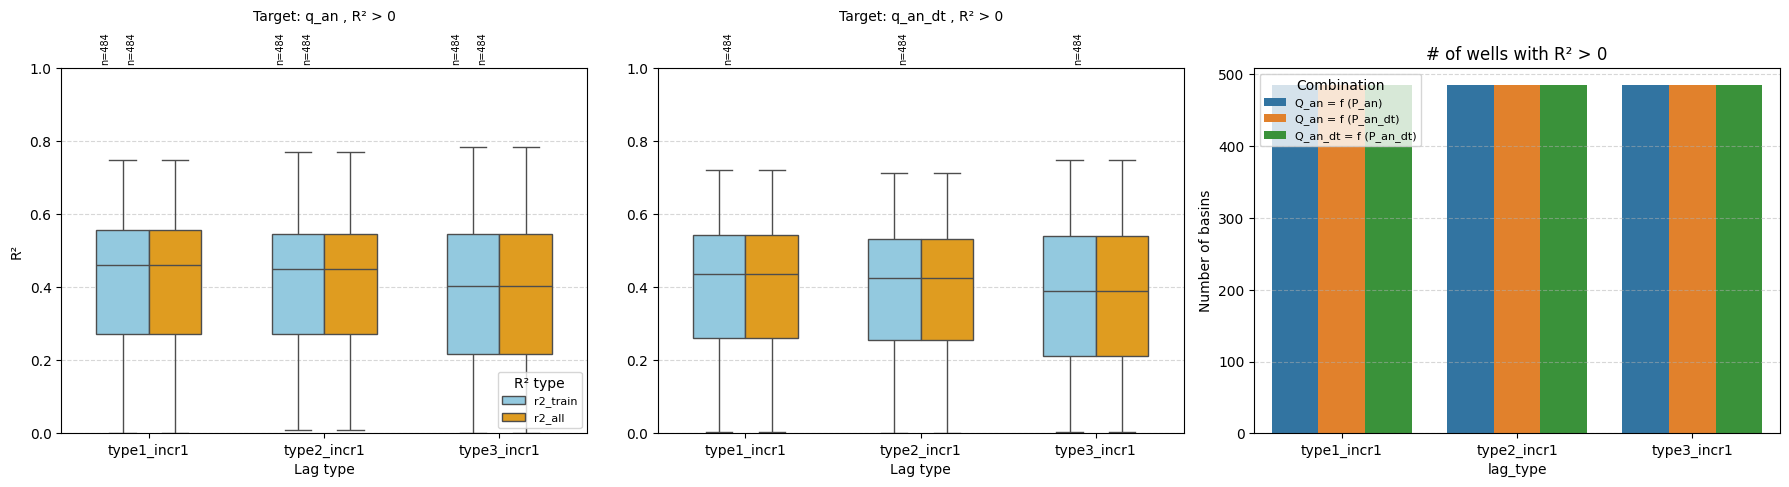

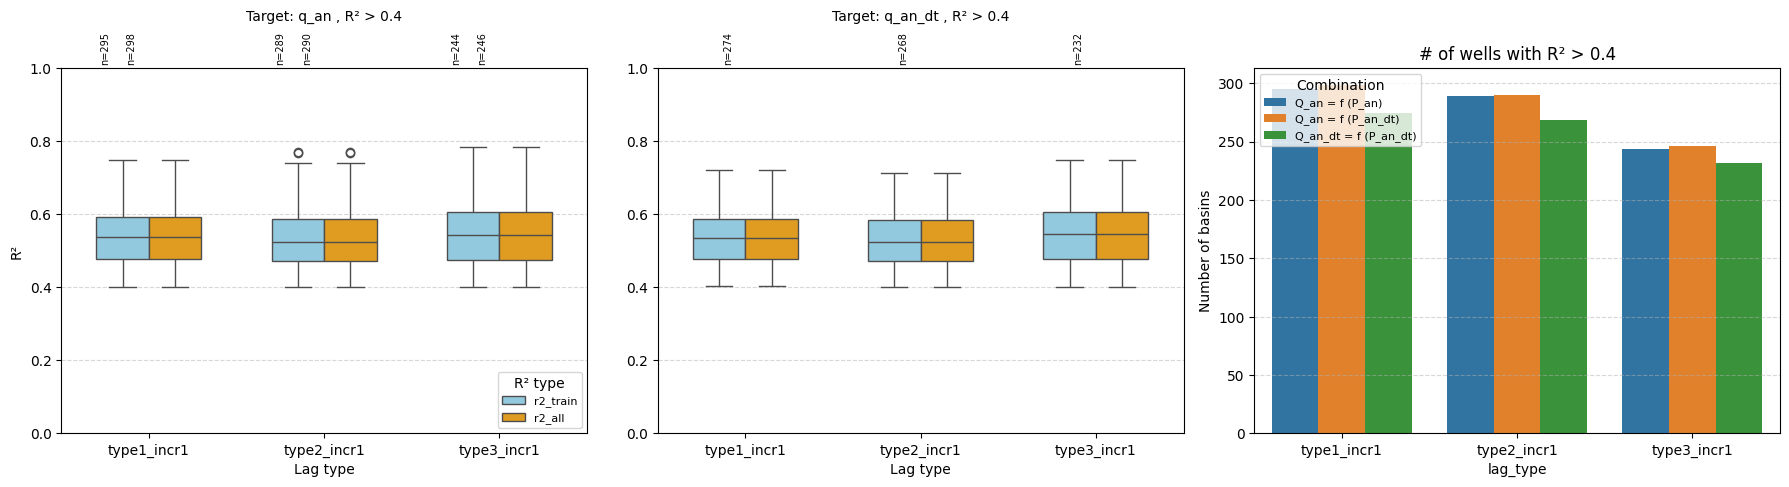

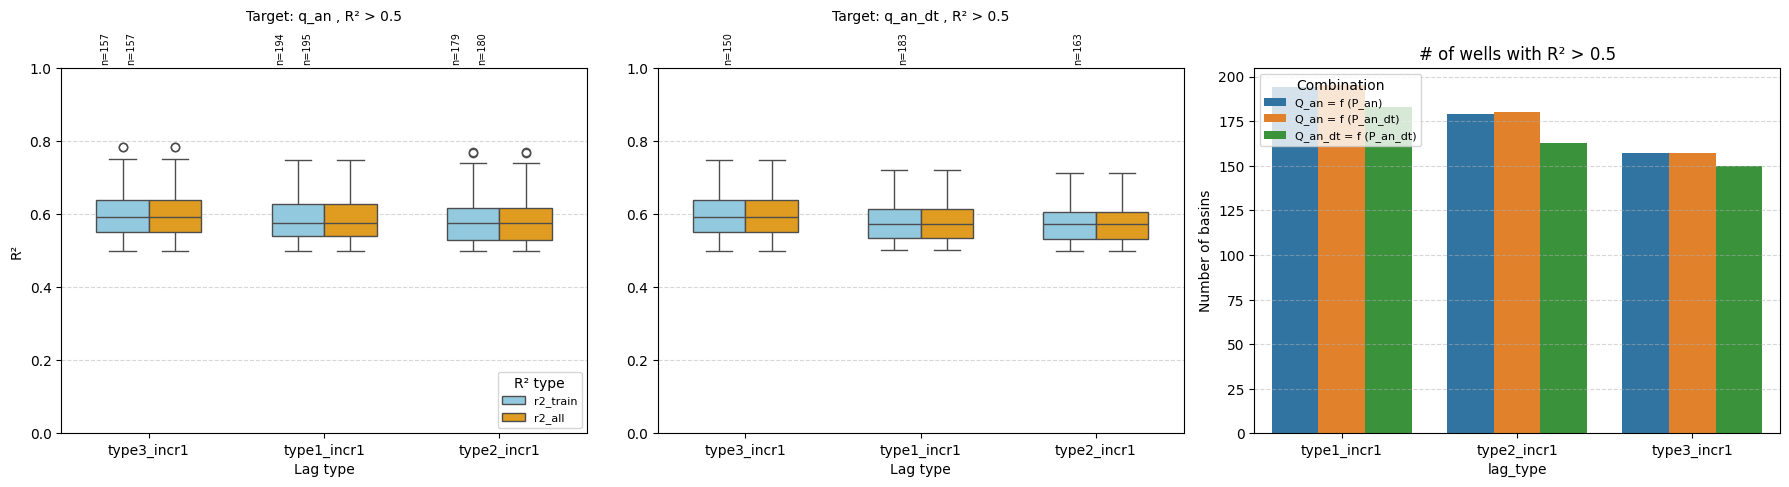

In [6]:
from pathlib import Path
# === Load R² CSV ===
out_figs = 'figs_r2'
Path(out_figs).mkdir(parents=True, exist_ok=True)

df_r2 = pd.read_csv('csv/r2_LR_rest_pos_False_trained_all.csv')  # or _False
filename = 'r2_LR_trained_all'

# df_r2 = pd.read_csv('csv/r2_LR_rest_pos_False_trained_pre_MD.csv')  # or _False
# filename = 'r2_LR_trained_preMD'

# --- Predictor/target combinations ---
combinations = [
    ('q_an', 'pr_an', None, 'Q_an = f (P_an)'),
    ('q_an', 'pr_an_dt', None, 'Q_an = f (P_an_dt)'),
    ('q_an_dt', 'pr_an_dt', None, 'Q_an_dt = f (P_an_dt)')
]
       
plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0,
    title_suffix=", R² > 0",
    filename= filename + "_all",
    out_figs=out_figs
)  

plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0.4,
    title_suffix=", R² > 0.4",
    filename= filename + "_0.4",
    out_figs=out_figs
) 


plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0.5,
    title_suffix=", R² > 0.5",
    filename= filename + "_0.5",
    out_figs=out_figs
) 

In [7]:
### CELL: Plot observed vs simulated time series per well

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

path_results = Path('csv')

# === Load data and where to save figures ===
df = pd.read_csv(path_results / 'q_sim_LR_trained_all.csv', parse_dates=['date'], dtype={'gauge_id': str})
df_r2 = pd.read_csv(path_results / 'r2_LR_rest_pos_False_trained_all.csv', dtype={'gauge_id': str})
out_dir = 'figs_obs_sim_trained_all'
Path(out_dir).mkdir(parents=True, exist_ok=True)
train_end = pd.to_datetime("2025-12-31")

# # === Load data and where to save figures ===
# df = pd.read_csv(path_results / 'gw_sim_LR_trained_pre_MD.csv', parse_dates=['date'], dtype={'gauge_id': str})
# df_r2 = pd.read_csv(path_results / 'r2_LR_rest_pos_False_trained_pre_MD.csv', dtype={'gauge_id': str})
# out_dir = 'figs_obs_sim_trained_pre_MD'
# Path(out_dir).mkdir(parents=True, exist_ok=True)
# train_end = pd.to_datetime("2009-12-31")

# === Define target/predictor pairs ===
combinations = [
    ('q_an', 'pr_an', None, 'Q_an ~ Pr_an'),
    ('q_an_dt', 'pr_an_dt', None, 'Q_an_dt ~ Pr_an_dt')
]

wells = df['gauge_id'].unique()
lag_types = df['lag_incr_rule'].unique()

# === Plot per well ===
eligible_wells = set(df_r2[df_r2['r2_all'] > 0.4]['gauge_id'].unique())
for cod in wells:
    if cod not in eligible_wells:
        continue
    subset_well = df[df['gauge_id'] == cod]
    if subset_well.empty:
        continue

    start, end = subset_well['date'].min(), subset_well['date'].max()
    fig, axs = plt.subplots(3, 2, figsize=(12, 9), sharex=True)
    axs = axs.ravel()

    for row, lag in enumerate(sorted(lag_types)):
        for col, (target, predictor, _, label) in enumerate(combinations):
            ax_idx = row * 2 + col
            ax = axs[ax_idx]

            combo_data = subset_well[
                (subset_well['lag_incr_rule'] == lag) &
                (subset_well['target'] == target) &
                (subset_well['predictor'] == predictor)
            ]

            if not combo_data.empty:
                incr = combo_data['lag_incr'].unique()[0]
                r2_row = df_r2[
                    (df_r2['gauge_id'] == cod) &
                    (df_r2['target'] == target) &
                    (df_r2['predictor'] == predictor) &
                    (df_r2['lag_incr_rule'] == lag)
                ]
                r2_all = r2_row['r2_all'].values[0] if not r2_row.empty else None
                title = f"{label}, lag windows: {lag}, incr: {incr}, r²: {r2_all:.2f}" if r2_all is not None else f"{label} ({lag}), R² = NA"

                p1 = ax.scatter(combo_data['date'], combo_data['target_val'], color='black', s=6, label='Obs (target)')
                p2, = ax.plot(combo_data['date'], combo_data['pred'], color='crimson', lw=1, label='Sim (target)')

                # Secondary: raw observations
                ax2 = ax.twinx()
                p3 = ax2.scatter(combo_data['date'], combo_data['raw_obs'], color='grey', s=2, alpha=0.6, label='Obs (raw)')
                ax2.tick_params(axis='y', labelcolor='grey')
                ax2.spines['right'].set_color('grey')
                ax2.yaxis.label.set_color('grey')

                # Training end line
                ax.axvline(train_end, color='grey', ls='--', lw=1)

                ax.set_title(title, fontsize=9)
                ax.grid(True)
                ax.set_xlim(start, end)

                if ax_idx == 0:
                    ax.legend(
                        handles=[p3, p1, p2],
                        labels=["Obs (raw)", "Obs (target)", "Sim (target)"],
                        fontsize=8,
                        loc='lower left',
                        frameon=True
                    )

                if col == 0:
                    ax.set_ylabel("Anomaly")
                if row == 2:
                    ax.set_xlabel("Date")
            else:
                ax.text(0.5, 0.5, "No data", ha='center', va='center')
                ax.set_axis_off()

    fig.suptitle(f"Basin {cod} – LR 6 predictors", fontsize=13)
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{cod}.png", bbox_inches='tight')
    plt.close()

print("LR Plots Finished! Finito! Terminado!")


LR Plots Finished! Finito! Terminado!
